## 1. Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from xgboost import plot_importance

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

## 2. Explorar y limpiar la data

### 2.1 Leer dataset

In [2]:
df = pd.read_csv('../data/data_caso_forecast.csv')
df.sample(5,random_state=42)    

,ds,y,precio,opu,feriados,cyber,mobility,oil_price,copper_price,perc_zero_stock
56,25-01-2021,6302,30380.84931,0.000000,0,0,-45.622061,52.554,3.5693,0.698347
89,13-09-2021,18982,27887.79588,0.724138,3,0,-21.969231,71.620,4.3039,0.083352
4,27-01-2020,0,26016.26202,0.137931,0,0,0.000000,52.730,2.6188,0.019411
45,09-11-2020,33422,28043.43321,0.000000,0,0,-39.406872,40.870,3.1800,0.245966
26,29-06-2020,13466,27311.80357,0.000000,1,0,-66.242315,39.944,2.7767,0.033333


### 2.2 Chequear types

De acuerdo al desafio se tiene lo siguiente:
- **ds**: semana de venta (fecha del primer día de la semana) &rarr; **datetime** 
- **y**: cantidad vendida en el periodo &rarr; **integer**
- **precio**: precio promedio de venta del periodo &rarr; **float**
- **opu**: porcentaje de los productos de la categoría que estuvieron en promoción &rarr; **float**
- **feriados**: indica el número de feriados que hubo en el periodo &rarr; **integer**
- **cyber**: variable dummy, indica si hubo cyber en el periodo &rarr; **integer (binary)**
- **mobility**: indicador de mobilidad de google (variable pandémica) &rarr; **float**
- **oil_price**: precios del petróleo &rarr; **float**
- **copper_price**: precios del cobre &rarr; **float**
- **perc_zero_stock**: porcentaje de tiendas con quiebre &rarr; **float**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ds               118 non-null    object 
 1   y                118 non-null    int64  
 2   precio           118 non-null    object 
 3   opu              118 non-null    float64
 4   feriados         118 non-null    int64  
 5   cyber            118 non-null    int64  
 6   mobility         118 non-null    float64
 7   oil_price        118 non-null    float64
 8   copper_price     118 non-null    float64
 9   perc_zero_stock  118 non-null    float64
dtypes: float64(5), int64(3), object(2)
memory usage: 9.3+ KB


De esta forma vamos a convertir en el tipo de dato correspondiente donde sea posible.

In [4]:
# Fechas en datetime
df['ds'] = pd.to_datetime(df.ds, format='%d-%m-%Y')

# Convertir en int
df['y'] = df['y'].astype(int) 
df['feriados'] = df['feriados'].astype(int) 
df['cyber'] = df['cyber'].astype(int) 

# Convertir float
df['opu'] = df['opu'].astype(float)
df['mobility'] = df['mobility'].astype(float)
df['oil_price'] = df['oil_price'].astype(float)
df['copper_price'] = df['copper_price'].astype(float)
df['perc_zero_stock'] = df['perc_zero_stock'].astype(float)


Donde la variable "precio" no fue posible convertir dado que cuenta con unos valores "#N/D"

In [5]:
df[df['precio'] == '#N/D']

,ds,y,precio,opu,feriados,cyber,mobility,oil_price,copper_price,perc_zero_stock
0,2019-12-30,6038,#N/D,0.0,1,0,0.0,61.660,2.8492,0.155448
1,2020-01-06,12040,#N/D,0.0,0,0,0.0,60.836,2.8521,0.095997


Los cuales corresponden a la última semana del año 2019 y la primera del 2020, que para este dataset son los primeros datos. Ya que el dataset es muy pequeño estos 2 datos corresponden cerca del 2% de los datos. En una primera instancia se podría buscar la forma de no perder esta data pero en este caso sería extrapolando lo cual no aportaría mucho en este caso, de esta forma se opta por eliminar esas filas.

In [6]:
# Eliminar esas filas
df = df[df['precio'] != '#N/D'].reset_index(drop=True)

# Convertir float
df['precio'] = df['precio'].astype(float)

De esta forma vemos que no hay nan values

In [7]:
df.isna().sum()

ds                 0
y                  0
precio             0
opu                0
feriados           0
cyber              0
mobility           0
oil_price          0
copper_price       0
perc_zero_stock    0
dtype: int64

### 2.3 Visualizar Data

Ahora visualicemoslos timeseries

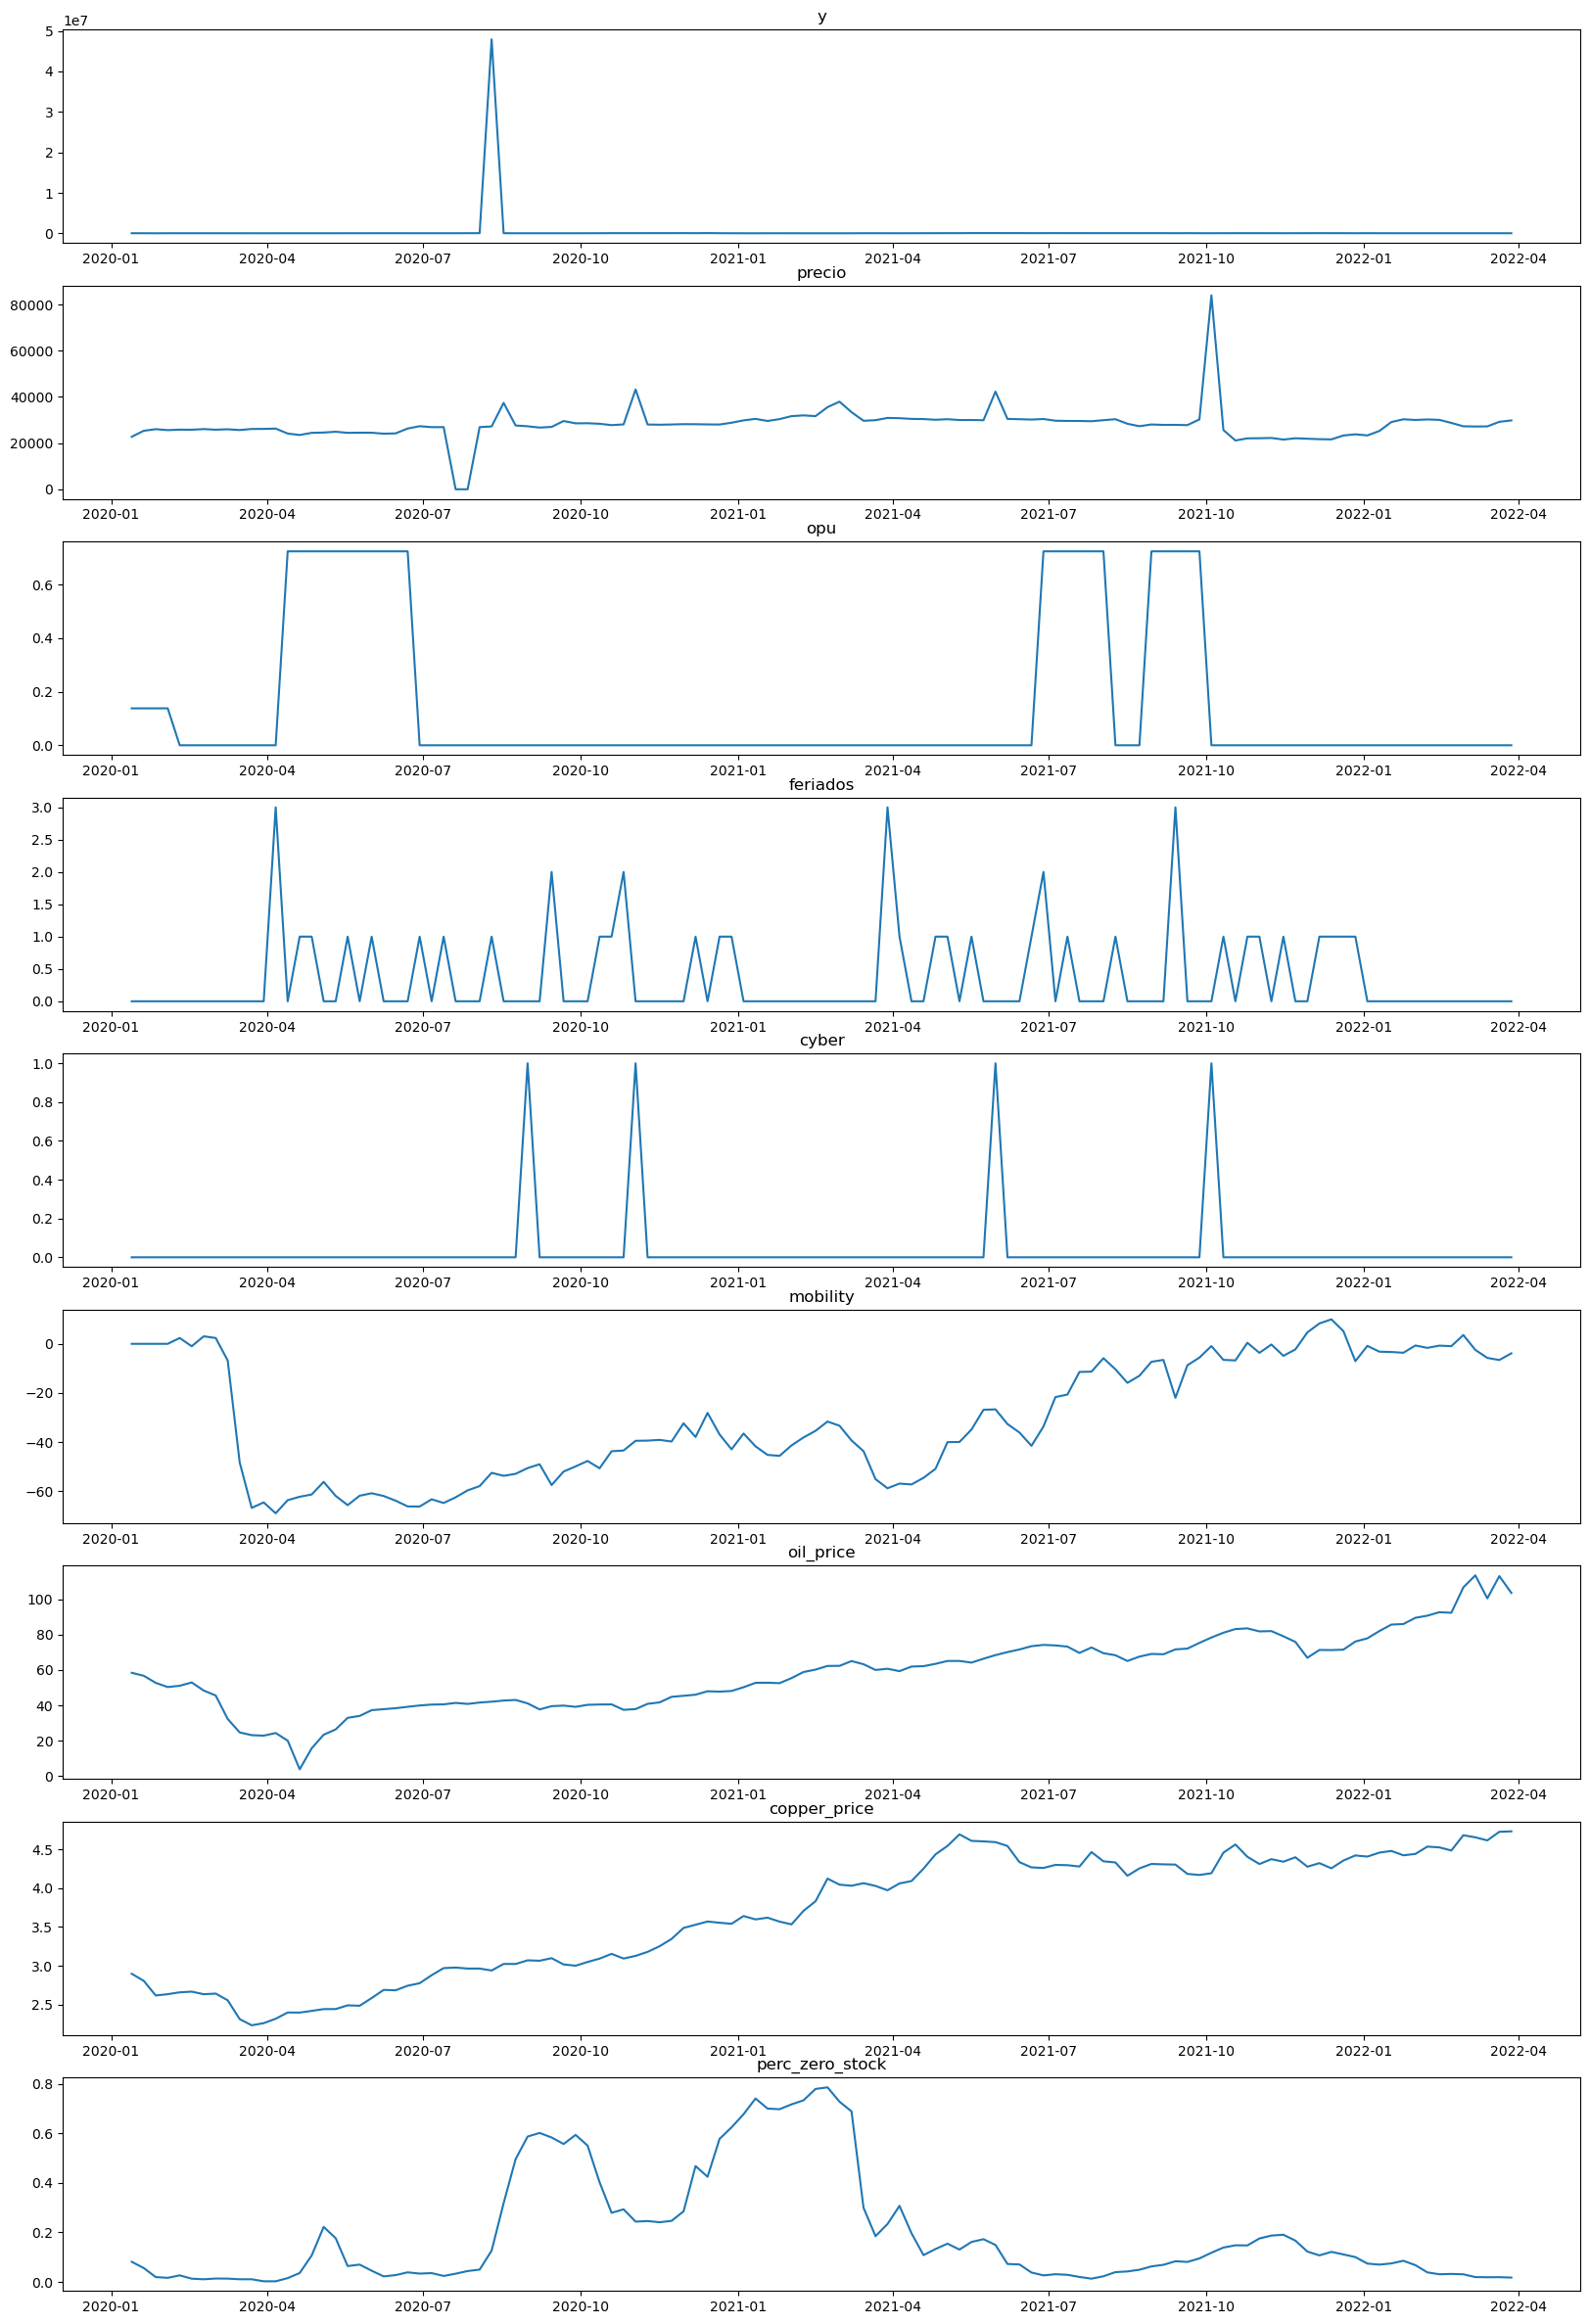

In [8]:
# Crear todos los timeseries
fig, axs = plt.subplots(nrows=len(df.columns)-1, ncols=1, figsize=(20, 30))
for i, col in enumerate(df.columns[1:]):
    axs[i].plot(df.ds,df[col])
    axs[i].set_title(col)

A priori pareceria un outlier el pico que se ve en la variable 'y', veamos sus valores vecinos

In [9]:
index = df[df['y'] == df.y.max()].index[0]
df.iloc[index-2:index+3]

,ds,y,precio,opu,feriados,cyber,mobility,oil_price,copper_price,perc_zero_stock
28,2020-07-27,20986,0.00000,0.0,0,0,-59.661844,40.820,2.9654,0.043708
29,2020-08-03,29168,26910.32864,0.0,0,0,-57.920434,41.614,2.9653,0.049567
30,2020-08-10,47912000,27213.84145,0.0,1,0,-52.540687,42.094,2.9402,0.126386
31,2020-08-17,20724,37410.42649,0.0,0,0,-53.745597,42.726,3.0250,0.318210
32,2020-08-24,7654,27615.37377,0.0,0,0,-52.937984,43.074,3.0242,0.496546


La cual es 3 ordenes de magnitud más grande que los vecinos y vemos que lo único que no esta en la tendencia de los datos es que hay un feriado, lo cual dificilmente podría explicar ese valor, en una primera impresión parece un error de tipeo donde los '0' no corresponden, de esta forma para no perder ese dato solo eliminaremos los 0.

In [10]:
df.loc[index,'y'] = 47912

Ahora la data se visualiza de esta forma

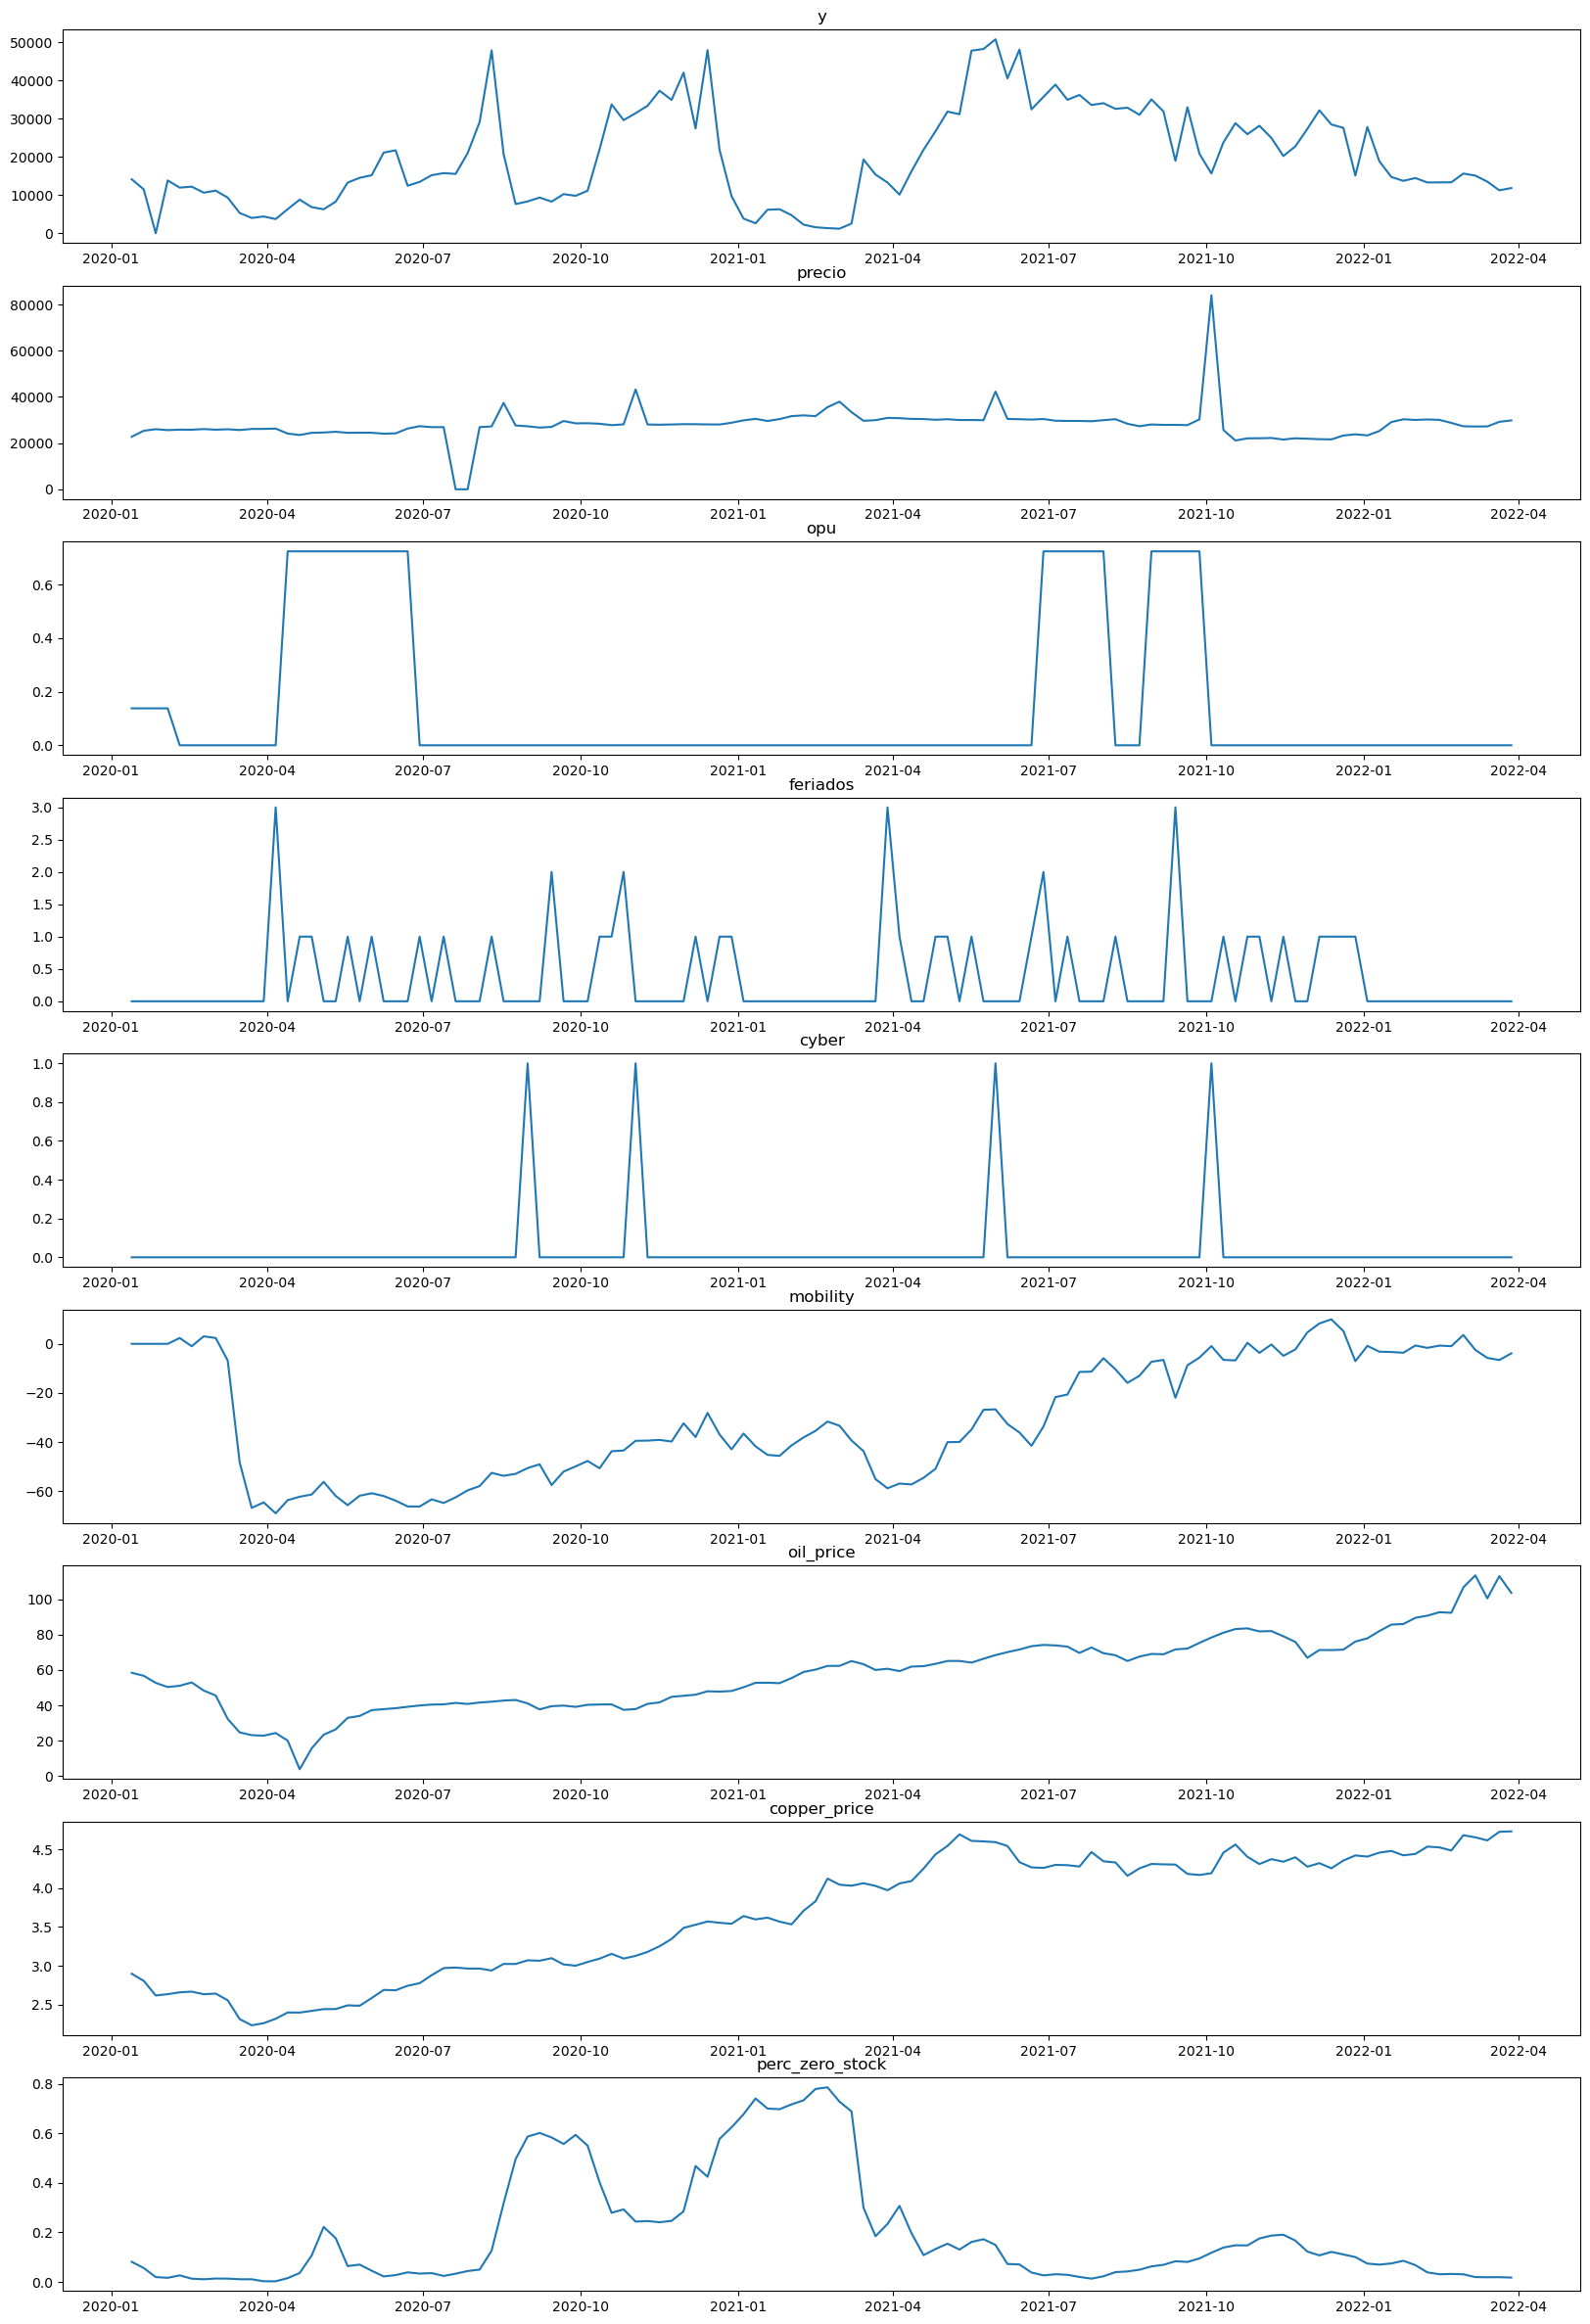

In [11]:
# Crear todos los timeseries
fig, axs = plt.subplots(nrows=len(df.columns)-1, ncols=1, figsize=(20, 30))
for i, col in enumerate(df.columns[1:]):
    axs[i].plot(df.ds,df[col])
    axs[i].set_title(col)

Ahora se exporta el dataset limpio

In [12]:
df.to_csv('../data/data_caso_forecast_clean.csv',index=False)

## 3. Análisis estadistico del problema

Cargando nuevamente el dataset

In [13]:
df = pd.read_csv('../data/data_caso_forecast_clean.csv')
df['ds'] = pd.to_datetime(df.ds,dayfirst=True)
df = df.set_index('ds')

Se realiza un análisis estadistico de la serie de tiempo, para eso visualicemos solo la demanda.

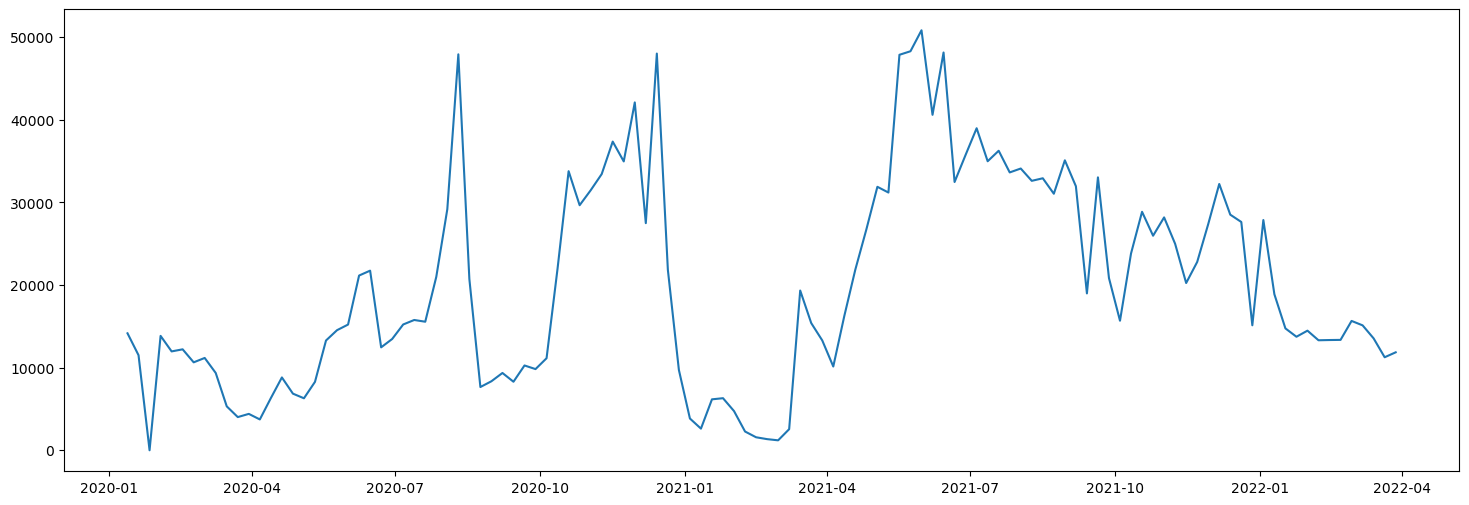

In [14]:
plt.figure(figsize=(18,6))
plt.plot(df.y)
plt.show()

### 3.1 Estacionalidad

Para estudiar la estacionalidad realizaremos el test de Dickey-Fuller Aumentado (ADF)

In [15]:
dftest = adfuller(df.y, autolag='AIC')
print(dftest) 

(-3.232017654249485, 0.018204581701958773, 0, 115, {'1%': -3.4885349695076844, '5%': -2.887019521656941, '10%': -2.5803597920604915}, 2104.320415624141)


Observando el valor p = 0.018 el cual es menor al nivel de significancia (0.05) y el valor de la estadistica de prueba = -3.2320 que es menor al nivel de significancia del 5%, se podría rechaza la hipotesis nula y asi considerar una serie es estacionaria. 

### 3.2 Autocorrelación y Autocorrelación Parcial

Ahora analizando la autocorrelación en los datos de la serie de tiempo se tiene lo siguiente

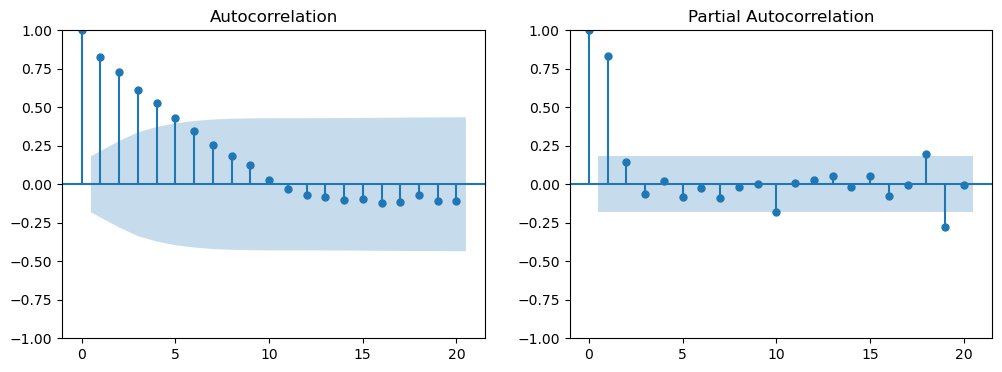

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

plot_acf(df.y, lags=20, ax=ax[0])
ax[0].set_title('Autocorrelation')

plot_pacf(df.y, lags=20, ax=ax[1])
ax[1].set_title('Partial Autocorrelation')

plt.show()

Con lo cual podriamos intentar en una primera instancia un modelo ARMA con parametros p=6 y d=2

## 4. Modelamiento

### 4.1 Feature Engineering

In [17]:
from sklearn.preprocessing import StandardScaler

# seleccionar las columnas que se quieren escalar
cols_to_scale = ['precio','opu','mobility','oil_price','copper_price','perc_zero_stock']

# crear el objeto StandardScaler
scaler = StandardScaler()

# ajustar y transformar las columnas seleccionadas
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])


Nuevos features relacionados a la fecha

In [18]:
def create_features(df):
    """
    Creates time series features from datetime index
    """
    
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.weekofyear
    
    return df

df = create_features(df) 

Agregar el lag y rolling mean

In [19]:
df['y_lag_1'] = df.y.shift(1)
df['y_lag_2'] = df.y.shift(2)
df['y_lag_3'] = df.y.shift(3)
df['y_lag_4'] = df.y.shift(4)

df['rolling_mean'] = df.y.rolling(window=4).mean()

### 4.2 Split Data

Dividimos la data en test y train

In [20]:
train_data, test_data = df[:int(len(df)*0.8)], df[int(len(df)*0.8):]

Definiendo target y features

In [21]:
target = ['y']
features = df.columns.tolist()[1:]

In [22]:
X_train, y_train = train_data[features],train_data[target] 
X_test, y_test = test_data[features],test_data[target] 

Exportar dataset de entrenamiento y test.

In [23]:
X_train.to_csv('../data/data_caso_forecast_clean_X_train.csv')
X_test.to_csv('../data/data_caso_forecast_clean_X_test.csv')
y_train.to_csv('../data/data_caso_forecast_clean_y_train.csv')
y_test.to_csv('../data/data_caso_forecast_clean_y_test.csv')

### 4.3 Desempeño Modelo Estadistico

#### 4.3.1 Entrenamiento

In [24]:
model = ARIMA(y_train, order=(4, 0, 2))
model_fit = model.fit() 

#### 4.3.2 Predicción

In [25]:
y_pred_arima = model_fit.predict(start=y_test.index[0], end=y_test.index[-1])

#### 4.3.3 Metricas de desempeño y visualización

In [26]:
# Calcular RMSE
rmse = np.sqrt(mean_squared_error(test_data.y, y_pred_arima))

# Calcular el MAPE
mape = mean_absolute_percentage_error(test_data.y, y_pred_arima)

print('El modelo ARIMA presenta un RMSE = {} y un MAPE = {}'.format(rmse,mape))

El modelo ARIMA presenta un RMSE = 7459.62948723136 y un MAPE = 0.31642455481125503


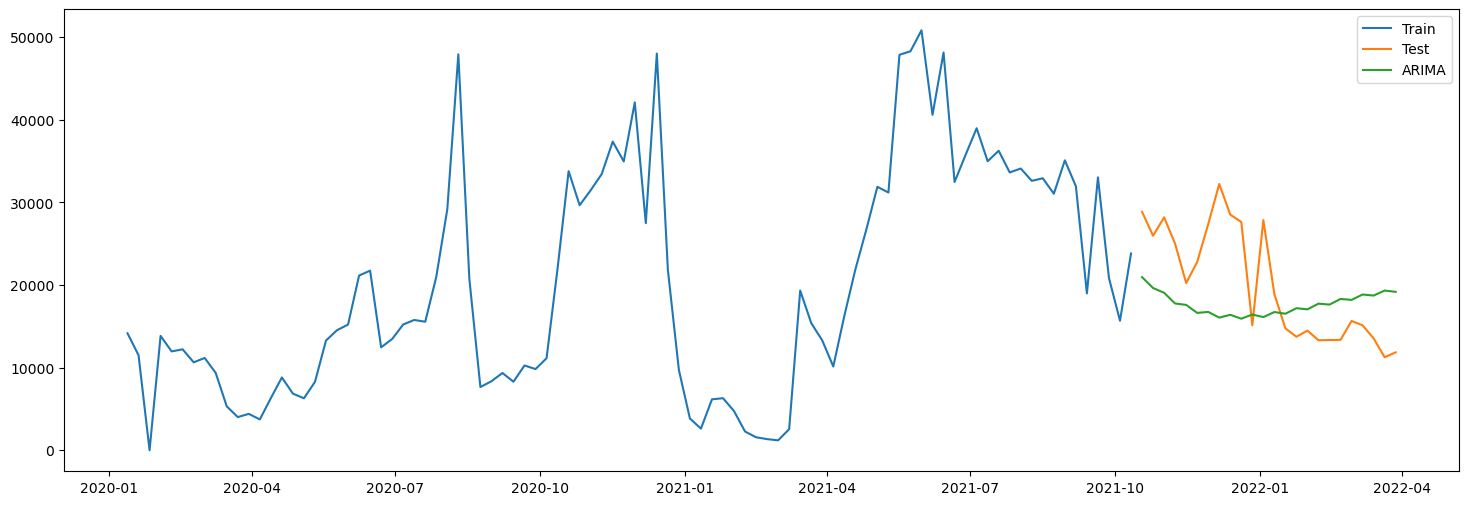

In [27]:
plt.figure(figsize=(18,6))
plt.plot(train_data.index,train_data.y,label = 'Train')
plt.plot(test_data.index,test_data.y,label = 'Test')
plt.plot(test_data.index, y_pred_arima, label = 'ARIMA')
plt.legend()
plt.show()

#### 4.3.4 Proyección Próximo Año

In [28]:
# Ultima fecha con información
start_date = test_data.index[-1]

# Arreglo de fechas semanales para el proximo año
date_range = pd.date_range(start=start_date, periods=52, freq='W')

# sumar un día a cada fecha en la serie para que coincida exactamente
one_day = timedelta(days=1)
new_dates = date_range.map(lambda x: x + one_day)

# Predicción modelo entrenado para el proximo año
y_pred_arima_new = model_fit.predict(start=new_dates[0], end=new_dates[-1])

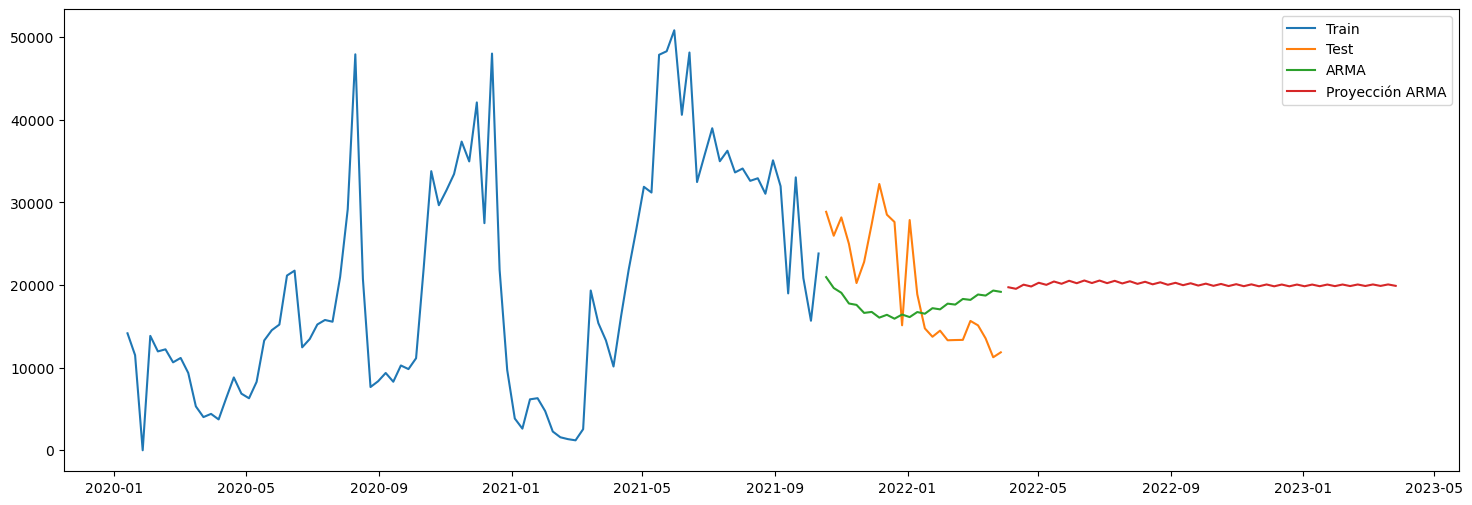

In [29]:
plt.figure(figsize=(18,6))
plt.plot(train_data.index,train_data.y,label = 'Train')
plt.plot(test_data.index,test_data.y,label = 'Test')
plt.plot(test_data.index, y_pred_arima, label = 'ARMA')
plt.plot(new_dates, y_pred_arima_new, label = 'Proyección ARMA')
plt.legend()
plt.show()
plt.show()

### 4.4 Modelos de Machine Learning

#### 4.4.1 Entrenamiento Modelo

In [30]:
xg_reg = XGBRegressor()
xg_reg.fit(X_train,y_train)

# lgbm_reg = LGBMRegressor()

# lgbm_reg.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

#### 4.4.2 Predicción

In [31]:
y_pred_xg = xg_reg.predict(X_test)
# y_pred_lgbm = xg_reg.predict(X_test)

#### 4.4.3 Metricas de Desempeño y Visualización

In [32]:
# Calcular RMSE
rmse = np.sqrt(mean_squared_error(test_data.y, y_pred_xg))

# Calcular el MAPE
mape = mean_absolute_percentage_error(test_data.y, y_pred_xg)

print('El modelo XGBoost presenta un RMSE = {} y un MAPE = {}'.format(rmse,mape))

El modelo XGBoost presenta un RMSE = 4737.127199633702 y un MAPE = 0.17023015171813524


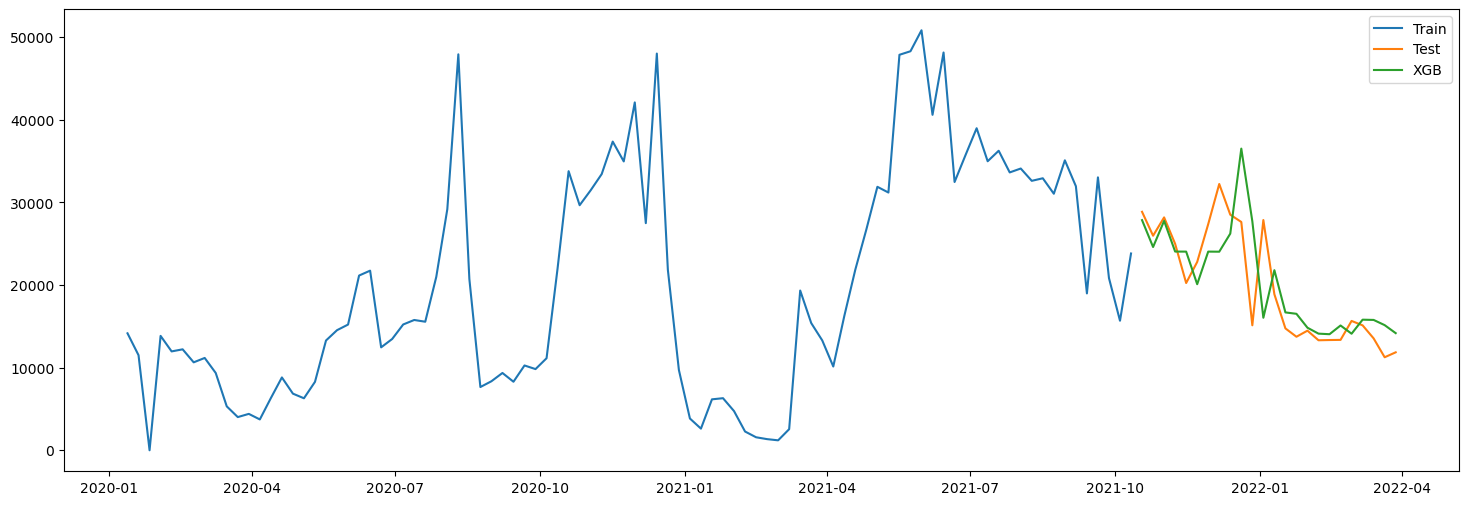

In [33]:
plt.figure(figsize=(18,6))
plt.plot(train_data.index,train_data.y,label = 'Train')
plt.plot(test_data.index,test_data.y,label = 'Test')
plt.plot(test_data.index, y_pred_xg, label = 'XGB')
# plt.plot(test_data.index, y_pred_lgbm, label = 'LGBM')
plt.legend()
plt.show()

#### 4.4.4 Feature Importance

Veamos cuales son los features de mayor relevancia

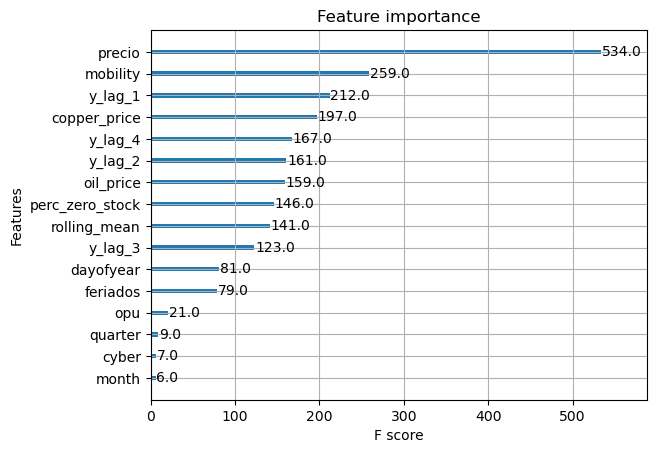

In [34]:
plot_importance(xg_reg)
plt.show()

#### 4.4.5 Actualizar Modelo

De los cuales podríamos no considerar 'opu', 'quarter', 'cyber' y 'month'

In [35]:
# Eliminar algunos features
new_features = X_train.columns.tolist()
del_features = ['opu','quarter','cyber','month']
new_features = [x for x in new_features if x not in del_features]

# Actualizar train y test
X_train = X_train[new_features]
X_test = X_test[new_features]

# Re entrenar modelo
xg_reg = XGBRegressor()
xg_reg.fit(X_train,y_train)

# Prediccion
y_pred_xg = xg_reg.predict(X_test)

Nuevos valores de las metricas

In [36]:
# Calcular RMSE
rmse = np.sqrt(mean_squared_error(test_data.y, y_pred_xg))

# Calcular el MAPE
mape = mean_absolute_percentage_error(test_data.y, y_pred_xg)

print('El modelo XGBoost presenta un RMSE = {} y un MAPE = {}'.format(rmse,mape))

El modelo XGBoost presenta un RMSE = 4575.970787798021 y un MAPE = 0.1684324443285016


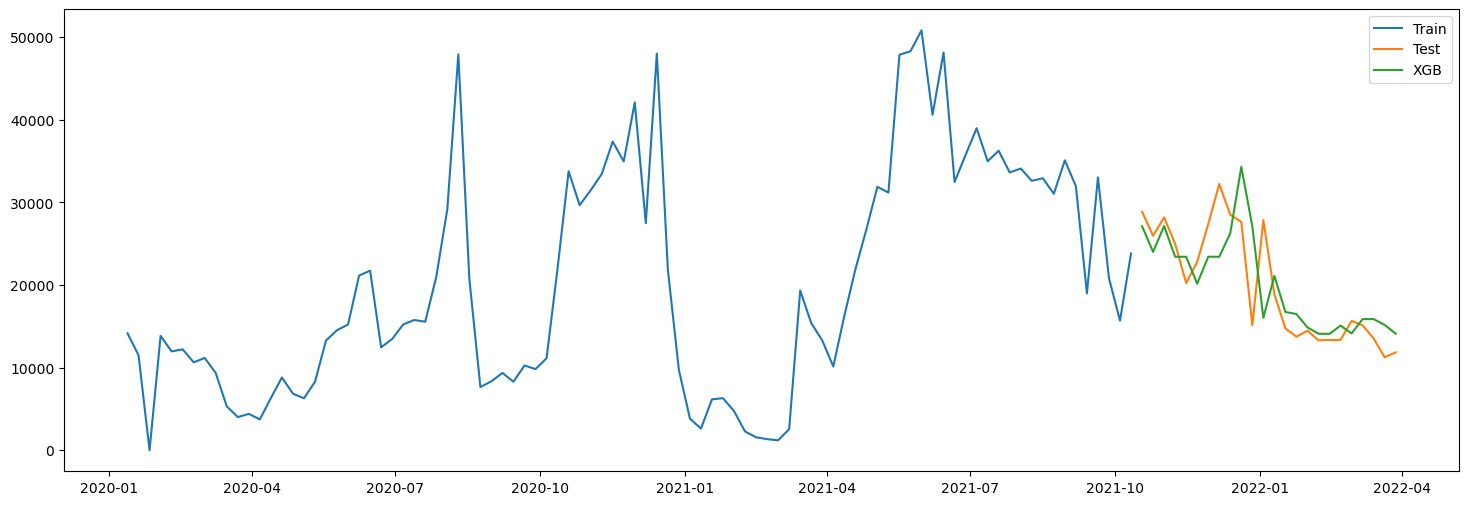

In [37]:
plt.figure(figsize=(18,6))
plt.plot(train_data.index,train_data.y,label = 'Train')
plt.plot(test_data.index,test_data.y,label = 'Test')
plt.plot(test_data.index, y_pred_xg, label = 'XGB')
# plt.plot(test_data.index, y_pred_lgbm, label = 'LGBM')
# plt.plot(test_data.index, y_pred_cat, label = 'CatB')
plt.legend()
plt.show()

#### 4.4.6 Supuestos para los Features

Generar Nuevo Dataframe con los features proyectados

In [38]:
df_new_dates = pd.DataFrame(index=new_dates, columns=X_test.columns)

In [39]:
# Dataframe de los ultimos 3 meses de entrenamiento
last_train_date = X_train.index[-1]
last_3 = last_train_date - timedelta(days=90)
df_last_3 = X_train[X_train.index > last_3]